<a href="https://colab.research.google.com/github/leehanchung/cs224w/blob/main/notebooks/XCS224W_Colab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Colab 5**

In this final Colab we will experiment with advanced topics in GNNs. Specifically, we will look at different techniques for scaling up GNNs using PyTorch Geometric, DeepSNAP and NetworkX. 

First, we will work with PyTorch Geometric's `NeighborSampler` to scale up training and testing on the OGB `arxiv` dataset.

Then, using DeepSNAP and NetworkX, we will implement our own simplified version of `NeighborSampler` and run experiments with different sampling ratios on the Cora graph.

Lastly, we will partition the Cora graph into clusters by using different partition algorithms and then train the models using a vanilla Cluster-GCN.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

# Device
You likely will want to us a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [1]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
  !pip install torch-geometric
  !pip install -q ogb
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git


Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html


In [2]:
import torch_geometric
torch_geometric.__version__

'2.0.2'

# 1) Neighbor Sampling

Neighbor Sampling, originally proposed in **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)), is a representative method to scale up GNNs. As we learned in lecture, rather than loading the entire graph into memory for each training loop, we can instead sample a mini-batch of the nodes we want to embed and **only** load the K-hop graph neighborhoods needed to embed these nodes. In this way we take advantage of the fact that the embedding of a node u only depends on its K-hop neighborhood. To further reduce the memory footprint and computational cost, we can choose to sample only a subset of a node's neighborhood during message passing and aggregation.

## Setup

In [3]:
import copy
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborSampler
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## PyTorch Geometric Neighbor Sampler

PyTorch Geometric has implemented Neighbor Samplinging through the [NeighborSampler](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborSampler) class. 
Neighbor sampling is based on building a node’s computation graph without storing irrelevant information for a given node, thus, making it more efficient. Each node produces a single computation graph, where for each node in a k-hop neighborhood, at most, $H_k$ neighbors are randomly sampled. Each node's  computation graph will therefore involve $\prod^K_{k=1} H_k$ leaf nodes for a K-layer GNN. The successive layers of each node's computation graph can be conceptualized as bi-partite graphs that represent each layer of message passing in the GNN as shown in figure below. The blue (or black) dots are source nodes residing at layer $k-1$, while the red dots represent target nodes at subsequent layer $k$.  It is important to stress the target nodes that are embedd in each layer are the final nodes in the left hand side of the bi-partite graph. Node computation graphs are combined when subsequently forming a batch. If you'd like to learn more about information on neighborhood sampling, this
**[blog](https://towardsdatascience.com/sampling-large-graphs-in-pytorch-geometric-97a6119c41f9)** provides an excellent description.

![img]( https://drive.google.com/uc?export=view&id=1QqcrEsN-HpSHgwHiOD4Dh6yIawZh0Pgj)


**PyG Docs**

The neighbor sampler from the “Inductive Representation Learning on Large Graphs” paper, which allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.

Given a GNN with  layers and a specific mini-batch of nodes node_idx for which we want to compute embeddings, this module iteratively samples neighbors and constructs bipartite graphs that simulate the actual computation flow of GNNs.

More specifically, sizes denotes how much neighbors we want to sample for each node in each layer. This module then takes in these sizes and iteratively samples sizes[l] for each node involved in layer l. In the next layer, sampling is repeated for the union of nodes that were already encountered. The actual computation graphs are then returned in reverse-mode, meaning that we pass messages from a larger set of nodes to a smaller one, until we reach the nodes for which we originally wanted to compute embeddings.

Hence, an item returned by NeighborSampler holds the current batch_size, the IDs n_id of all nodes involved in the computation, and a list of bipartite graph objects via the tuple (edge_index, e_id, size), where edge_index represents the bipartite edges between source and target nodes, e_id denotes the IDs of original edges in the full graph, and size holds the shape of the bipartite graph. For each bipartite graph, target nodes are also included at the beginning of the list of source nodes so that one can easily apply skip-connections or add self-loops.


If you are interested in memory-efficient aggregations, please refer to PyG's [Memory-Efficient Aggregations](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html).  Following is an example that uses the Neighbor Sampling method on training the OGB `arxiv` dataset. 

In [4]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset_name = 'ogbn-arxiv'
  dataset = PygNodePropPredDataset(name=dataset_name,
                                  transform=T.ToSparseTensor())
  data = dataset[0]
  data.adj_t = data.adj_t.to_symmetric()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  print('Device: {}'.format(device))

  data = data.to(device)
  split_idx = dataset.get_idx_split()
  train_idx = split_idx['train'].to(device)

  sampled_subgraph_batch_loader = None
  full_subgraph_loader = None
  
  ############# Your code here ############
  ## (~2 line of code)
  ## Note:
  ## 1. Construct the NeighborSampler `sampled_subgraph_batch_loader`. 
  ##    Use a batch size of 4096, turn shuffle on, and only 
  ##    use train_idx nodes to create mini-batches. During sampling,
  ##    sample up to 10 neighbors in layer one and 5 neighbors in layer 2.
  ## 2. Construct the NeighborSampler `full_subgraph_loader`. 
  ##    Use a batch size of 4096 and turn shuffle off. Sample all neighbors
  ##    for only ONE layer and consider all nodes for sampling mini-batches!
  ##    We use this loader for the inference / test phase of our model. In the
  ##    inference function we will why we only need to sample complete
  ##    1-hop neighborhoods.
  ## 3. Look at the NeighborSampler documentation to figure out which 
  ##    parameters you need to set:
  ##    https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborSampler
  sampled_subgraph_batch_loader = NeighborSampler(
      data.adj_t,
      node_idx=train_idx,
      sizes=[10, 5],
      batch_size=4096,
      shuffle=True,
      num_workers=2,
  )
  full_subgraph_loader = NeighborSampler(
      data.adj_t,
      node_idx=None,
      sizes=[-1],
      batch_size=4096,
      shuffle=False,
      num_workers=2,
  )
  #################################################################################

  evaluator = Evaluator(name='ogbn-arxiv')

Device: cuda


## GNN Model

After creating our `NeighborSampler`, we also need to modify our model to support the mini-batch training.

The `forward` function will take the node feature `x` and a list of three-element tuples `adjs`. Each element in `adjs` contains following elements:
* `edge_index`: The edge index tensor between source and destination nodes, which forms a bipartite grpah.
* `e_id`: The indices of the edges in the original graph.
* `size`: The shape of the bipartite graph, in (*number of source nodes*, *number of destination nodes*) format.


In [5]:
class SAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        for i in range(num_layers - 2):
            self.convs.append(
                SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, output_dim))

        self.softmax = torch.nn.LogSoftmax(dim=1)

        self.dropout = dropout

        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adjs, mode="batch"):
        if mode == "batch":
            ############# Your code here ############
            ## (~7 line of code)
            ## Note:
            ## 1. Loop through the list `adjs` and apply L GNN layers.
            ##    Refer to the description above for the elements in each tuple
            ##    adjs[l].
            ## 2. Our GNN model is of the form:
            ##      conv -> bn -> relu -> dropout -> ... -> conv
            ## 3. As described above, each layer is defined by a bipartite graph
            ##    between (source nodes and target nodes), where the size parameter
            ##    tells us many source nodes and target nodes we have.
            ## 4. Rather than passing just x to the SAGEConv layer, you can pass
            ##    a tuple of the form (x_src, x_target). With this formulation
            ##    we only produce embeddings for the `x_target` nodes and use
            ##    `x_source` as the nodes needed for message passing.  
            ##
            ##    Hint: 
            ##      - Target nodes are included as the first nodes in the source nodes.
            ##      - The target nodes for layer (l) become the source nodes 
            ##      for layer (l+1)!
            ## https://github.com/pyg-team/pytorch_geometric/blob/master/examples/ogbn_products_sage.py
            for i, (edge_index, _, size) in enumerate(adjs):              # 1
                x_target = x[:size[1]]                                    # 3
              
                x = self.convs[i]((x, x_target), edge_index)              # 4
                if i != self.num_layers - 1:                              # 2
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
            #####################################
        else:
            for i, conv in enumerate(self.convs):
                x = conv(x, adjs)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        return self.softmax(x)
    
    def inference(self, x_all, all_loader):
        # This function will be called in test
        for i in range(self.num_layers):
            xs = []
            ############# Your code here ############
            ## (~7 line of code)
            ## Note:
            ## 1. Very similar idea to the forward function!
            ## 2. Looping through all_loader to apply conv layer i to each
            ##    batch of nodes, where all_loader returns tuples of:
            ##      - batch_size
            ##      - node_indeces of the nodes we want to sample from x_all
            ##      in the current batch.
            ##      - adj: see above for what is in the tuple adj.
            ## 3. After selecting nodes using the node_indeces, follow the same
            ##    steps as the forward function.
            ## 4. Since we are doing mini-batches of nodes, we now need
            ##    to append the generated embeddings to compute all
            ##    the node embeddings!
            ## 5. Rember to move `adj` and the selected nodes for each batch to
            ##    the GPU `device`.
            for batch_size, n_id, adj in all_loader:                      # 2
                edge_index, _, size = adj.to(device)                      # 5
                x = x_all[n_id].to(device)                                # 3, 5
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
                xs.append(x.cpu())                                        # 4
            x_all = torch.cat(xs, dim=0)
            #####################################            
            # Concatenate all updated embeddings into one tensor.
            # We simulate the update process at the end of message
            # passing. Because of this we only have to sample 1-hop neighborhoods
            # for our full_subgraph_loader!
            x_all = torch.cat(xs, dim=0)

        return x_all

## Training and Testing

Now lets implement the training and testing functions.

In both training and testing, we need to sample batch from the dataloader.

Each batch in the `NeighborSampler` dataloader holds three elements:
* `batch_size`: The batch size specified in the dataloader.
* `n_id`: All nodes (in index format) used in the adjacency matrices.
* `adjs`: The three-element tuples.

In [6]:
def train(model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch"):
    model.train()

    total_loss = 0
    if mode == "batch":
        for batch_size, n_id, adjs in train_loader:
            # Move all adj sparse tensors to GPU
            adjs = [adj.to(device) for adj in adjs]
            optimizer.zero_grad()

            # Index on the node features
            out = model(data.x[n_id], adjs)
            train_label = data.y[n_id[:batch_size]].squeeze(-1)
            loss = loss_fn(out, train_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    else:
        optimizer.zero_grad()
        out = model(data.x, data.adj_t, mode=mode)[train_idx]
        train_label = data.y.squeeze(1)[train_idx]
        loss = loss_fn(out, train_label)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

    return total_loss

@torch.no_grad()
def test(model, data, all_loader, split_idx, evaluator, mode="batch", save_model_results=False):
    model.eval()

    if mode == "batch":
        out = model.inference(data.x, all_loader)
    else:
        out = model(data.x, data.adj_t, mode="all")

    y_true = data.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-arxiv_' + mode + '.csv', sep=',', index=False)

    return train_acc, valid_acc, test_acc

## Mini-batch Training

Test our model using mini-batch training, based on our NeighborSampler!

In [7]:
import pandas as pd

if 'IS_GRADESCOPE_ENV' not in os.environ:
  args = {
      'device': device,
      'num_layers': 2,
      'hidden_dim': 128,
      'dropout': 0.5,
      'lr': 0.01,
      'epochs': 100,
  }

  batch_model = SAGE(data.num_features, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)
  batch_model.reset_parameters()

  optimizer = torch.optim.Adam(batch_model.parameters(), lr=args['lr'])
  loss_fn = F.nll_loss

  best_batch_model = None
  best_valid_acc = 0

  batch_results = []

  for epoch in range(1, 1 + args["epochs"]):
      loss = train(batch_model, data, sampled_subgraph_batch_loader, train_idx, optimizer, loss_fn, mode="batch")
      result = test(batch_model, data, full_subgraph_loader, split_idx, evaluator, mode="batch")
      batch_results.append(result)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
          best_valid_acc = valid_acc
          best_batch_model = copy.deepcopy(batch_model)
      print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')
  best_result = test(best_batch_model, data, full_subgraph_loader, split_idx, evaluator, mode="batch", save_model_results=True)
  train_acc, valid_acc, test_acc = best_result
  print(f'Best model: '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 39.7248, Train: 62.44%, Valid: 63.88% Test: 64.45%
Epoch: 02, Loss: 28.5223, Train: 67.31%, Valid: 66.74% Test: 65.97%
Epoch: 03, Loss: 26.5680, Train: 69.19%, Valid: 68.76% Test: 67.62%
Epoch: 04, Loss: 25.4684, Train: 69.58%, Valid: 68.79% Test: 68.18%
Epoch: 05, Loss: 24.9500, Train: 70.43%, Valid: 69.20% Test: 68.02%
Epoch: 06, Loss: 24.5351, Train: 71.22%, Valid: 69.57% Test: 69.14%
Epoch: 07, Loss: 24.2229, Train: 70.90%, Valid: 69.05% Test: 68.40%
Epoch: 08, Loss: 23.9724, Train: 71.41%, Valid: 69.11% Test: 67.79%
Epoch: 09, Loss: 23.7119, Train: 72.04%, Valid: 69.50% Test: 68.19%
Epoch: 10, Loss: 23.5664, Train: 72.42%, Valid: 70.53% Test: 70.19%
Epoch: 11, Loss: 23.3254, Train: 72.35%, Valid: 69.72% Test: 68.37%
Epoch: 12, Loss: 23.0401, Train: 72.74%, Valid: 70.01% Test: 69.13%
Epoch: 13, Loss: 22.9589, Train: 73.14%, Valid: 70.61% Test: 69.90%
Epoch: 14, Loss: 22.7618, Train: 72.38%, Valid: 68.26% Test: 65.85%
Epoch: 15, Loss: 22.7350, Train: 73.44%, Valid: 

## **Question 1:** What is the maximum accuracy obtained on the test set using mini-batch training? (10 points)

Running the cell above will show the results of your best model and save your best model's predictions to a file named ogbn-arxiv_batch.csv'.

As we have seen before you can view this file by clicking on the Folder icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.

## Full-batch Training

Now for reference, we will compare training over all the nodes using full-batch mode (i.e. as we have done in the previous Colabs).

In [8]:
if 'IS_GRADESCOPE_ENV' not in os.environ:  
  # Use the same parameters for a full-batch training
  args = {
      'device': device,
      'num_layers': 2,
      'hidden_dim': 128,
      'dropout': 0.5,
      'lr': 0.01,
      'epochs': 100,
  }

  all_model = SAGE(data.num_features, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)
  all_model.reset_parameters()

  optimizer = torch.optim.Adam(all_model.parameters(), lr=args['lr'])
  loss_fn = F.nll_loss

  best_all_model = None
  best_valid_acc = 0

  all_results = []

  for epoch in range(1, 1 + args["epochs"]):
      # NOTE: For the full batch model, the NeighborSampler loader is not used!
      loss = train(all_model, data, sampled_subgraph_batch_loader, train_idx, optimizer, loss_fn, mode="all")
      result = test(all_model, data, full_subgraph_loader, split_idx, evaluator, mode="all")
      all_results.append(result)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
          best_valid_acc = valid_acc
          best_all_model = copy.deepcopy(all_model)
      print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')
  best_result = test(best_all_model, data, full_subgraph_loader, split_idx, evaluator, mode="all")
  train_acc, valid_acc, test_acc = best_result
  print(f'Best model: '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.9069, Train: 31.08%, Valid: 31.70% Test: 28.06%
Epoch: 02, Loss: 2.5612, Train: 32.69%, Valid: 35.79% Test: 35.02%
Epoch: 03, Loss: 2.1940, Train: 35.58%, Valid: 42.07% Test: 44.27%
Epoch: 04, Loss: 2.0097, Train: 36.00%, Valid: 42.64% Test: 46.43%
Epoch: 05, Loss: 1.8677, Train: 36.80%, Valid: 41.58% Test: 45.62%
Epoch: 06, Loss: 1.7597, Train: 40.06%, Valid: 43.99% Test: 47.87%
Epoch: 07, Loss: 1.6778, Train: 44.58%, Valid: 48.58% Test: 51.73%
Epoch: 08, Loss: 1.6113, Train: 48.64%, Valid: 52.53% Test: 55.16%
Epoch: 09, Loss: 1.5612, Train: 51.50%, Valid: 55.31% Test: 57.26%
Epoch: 10, Loss: 1.5154, Train: 53.30%, Valid: 56.79% Test: 58.41%
Epoch: 11, Loss: 1.4736, Train: 54.68%, Valid: 57.79% Test: 59.35%
Epoch: 12, Loss: 1.4397, Train: 55.87%, Valid: 58.66% Test: 60.00%
Epoch: 13, Loss: 1.4125, Train: 57.02%, Valid: 59.64% Test: 60.70%
Epoch: 14, Loss: 1.3921, Train: 58.28%, Valid: 60.44% Test: 61.23%
Epoch: 15, Loss: 1.3749, Train: 59.37%, Valid: 61.35% Test: 61

## Visualization

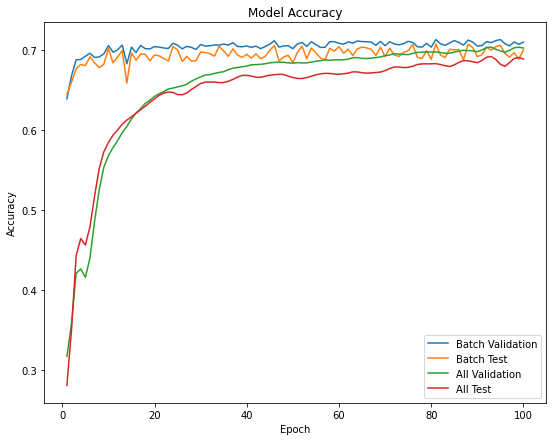

In [9]:
import numpy as np
from matplotlib import pyplot as plt

if 'IS_GRADESCOPE_ENV' not in os.environ:
  batch_results = np.array(batch_results)
  all_results = np.array(all_results)

  x = np.arange(1, 101)

  plt.figure(figsize=(9, 7))

  plt.plot(x, batch_results[:, 1], label="Batch Validation")
  plt.plot(x, batch_results[:, 2], label="Batch Test")
  plt.plot(x, all_results[:, 1], label="All Validation")
  plt.plot(x, all_results[:, 2], label="All Test")
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

# 2) Neighbor Sampling with Different Ratios

Next, we will implement our own simplified version of Neighbor Sampling using DeepSNAP and NetworkX. Then we will use our sampler to train models with different neighborhood sampling ratios and compare their performance.

To make our experiments faster, we will use the Cora graph.

## Setup

In [ ]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

if 'IS_GRADESCOPE_ENV' not in os.environ:
  pyg_dataset = Planetoid('./tmp', "Cora")

## GNN Model

We use a simple GraphSage GNN model, which we provide to you below. Similar to in section one, notice the slightly different implementations of the forward method depending on the data `mode`. When `mode = "batch"` we use Neighbor sampling. Thus, the data parameter contains our graphs node features (`x`) and a list `edge_indeces` containing the connectivity of each GNN layer (i.e. an edge_index for each layer, defining the bipartite neighborhood computation graph). 

**NOTE:** Refer to sections *Neighbor Sampling* and *PyTorch Geometric Neighbor Sampler* above for a detailed overview of the Neighbor Sampling technique.

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        self.dropout = args['dropout']
        self.num_layers = args['num_layers']

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        for l in range(self.num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, mode="batch"):
        # Observe the difference between mode == "batch" and mode == "all".
        # In mode == "batch" we pass in an edge index for each conv layer
        # corresponding to that layer's bipartite graph structure.
        if mode == "batch":
            edge_indices, x = data
            for i in range(len(self.convs) - 1):
                edge_index = edge_indices[i]
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
        else:
            x, edge_index = data.node_feature, data.edge_index
            for i in range(len(self.convs) - 1):
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_index)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

## Implementing Neighbor Sampling

Now let's take a stab at implementing our own basic version of Neighbor Sampling using DeepSNAP and NetworkX. To decompose the process, we will define several helper functions before finaling defining our own `neighbor_sampling` function! 

**NOTE:** Before working through this section, we highly recommend reviewing sections `Neighbor Sampling` and `PyTorch Geometric Neighbor Sampler`. Specifically, it is important to understand how we explicitly define an `edge_index` for each GNN layer, representing the bipartite computation graph connecting the `target_nodes` that we are embedding for that layer to their relavent neighbors from the previous layer needed for message passing. 

## **Question 2.1a**: Implementing the `sample_neighbors` function. (2.5 points)

In [ ]:
def sample_neighbors(nodes, G, ratio, all_nodes):
    # TODO: Implement a function that takes as input a set of nodes, 
    # a NetworkX graph G, and a neighbor sampling ratio and returns:
    #   1. A set of the sampled nodes
    #   2. A set union between `all_nodes` and the newly sampled neighbor nodes.
    #      This allows us to track the nodes needed across all message passing layers.
    #   3. The set of edges connecting the sampled neighboring nodes to our inpute
    #      set of nodes. Represents a bi-partite graph between targets (nodes)
    #      and source (neighbor) nodes.

    neighbors = set()
    edges = []

    ############# Your code here ############
    ## (~8-10 line of code)
    ## Note:
    ## 1. You will will need to sample neighbors from each node given to you in 
    ##    `nodes` list. 
    ##    Hint: Used graph `G` to assist in obtaining the neighbors of each node. 
    ## 2. Randomly sample neighbors without replacement (i.e. the same neighbors 
    ##    should not be selected more than once for a given node) 
    ## 3. The neighbors are stored in a set data structure to ensure that duplicates
    ##    are avoided.  This is useful as the set union will be taken with `all_nodes`. 
    ## 5. The edges list should contain all edges sampled in the form of a tuple
    ##    of (neighbor, node)  
    
    
    ########################################## 
    return neighbors, neighbors.union(all_nodes), edges
  
if 'IS_GRADESCOPE_ENV' not in os.environ:
  graphs_train, _, _ = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]

  nodes = [15, 16, 17]
  neighbors_full, _, _ = sample_neighbors(nodes, graph_train.G, 1, set())
  neighbors_sampled, _, _ = sample_neighbors(nodes, graph_train.G, 0.3, set())
  print ("Neighbors with ratio = 1:", neighbors_full)
  print ("Neighbors with ratio = 0.5:", neighbors_sampled)
  # Note that this is not expected to be 0.3. Since we apply
  # our sampling ratio for each node, the number of neighbors
  # for each node may not evenly divide by the ratio   
  print ("Ratio of sampled neighbors:", len(neighbors_sampled) / len(neighbors_full))

## Tensor transformation and node relabeling helper functions. 

In [ ]:
def nodes_to_tensor(nodes):
    """
      Transforms a set of nodes into a node index tensor.
    """

    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index


def edges_to_tensor(edges):
    """
      Transforms a list of undirected edges into the corresponding PyG
      edge_index tensor representation. Notice that we explicitly make
      sure to include both edge directions.  
    """

    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)
    edge_index = edge_index.permute(1, 0)

    return edge_index

def relabel(nodes, labeled_nodes, edges_list):
    """
      Relabel nodes with 0 based indeces.
      
      During the sampling process, we are likely to sample a list of
      non-continuous node ids. However, our GNN models rely on continuous
      0 based indexing to index into the rows of our node features matrix 
      based on edges in the graph (edge_index)
    """

    relabeled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:
        relabeled_edges = []
        for edge in orig_edges:
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabeled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]

    return relabeled_edges_list, relabeled_nodes, relabeled_labeled_nodes


## **Question 2.1b**: Putting it all together - Implementing our own Neighbor Sampling function. (2.5 points)

Now that we've developed a better understanding of what the Neighbor Sampling funciton does, we will implement our own version.  Instead of choosing $H_k$ number of samples at each layer, we will use a ratio of the number of neigbors that a givn node has.  Can you think of the pros and cons of using a ratio of the number of neighbors for a node at different layers?  

In [ ]:
def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # TODO: Implement a function that performs Neighbor Sampling on an input
    # graph G for a K layer GNN. Notice that len(ratios) = K + 1. Ratios[-1]
    # determines size of our mini-batch (i.e. the number of labeled 
    # nodes we sample computation graphs for). 

    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes

    ############# Your code here ############
    ## (~4-6 line of code)
    ## Note:
    ## 1. Using your previously defined `sample_neighbors` function, build up the 
    ##    nodes_list and edges_list for our K layer network.
    ## 2. nodes_list is a list where node_list[i] is set of nodes used for message
    ##    passing in layer i+1 of our GNN (i.e. level i in our computation graph).
    ##    Notice, node_list[-1] represents the target nodes we want to 
    ##    embedd in the mini-batch.
    ## 3. edge_list is a list of the bi-partite edge conections between layers
    ##    in the computation graph.
    ## 4. all_nodes is used to track all the nodes needed for message passing.
    ## 5. Remember in a GNN, information flows from the base of the computation
    ##    graph to the root. How does this affect the way we add to the nodes_list 
    ##    and edge_list, as well as how we read from ratios (ratios[-1] 
    ##    represents the root nodes in our computation graph)?


    #########################################

    relabled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes = \
        relabel(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(relabeled_all_nodes)
    # All node features that will be used
    node_feature = graph.node_feature[node_index]
    edge_indices = [edges_to_tensor(edges) for edges in relabled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    log = "Sampled {} nodes, {} edges, {} labeled nodes"
    print(log.format(node_feature.shape[0], edge_indices[0].shape[1] // 2, node_label_index.shape[0]))
    return node_feature, edge_indices, node_label_index

if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Need to define some basic test! Primarily to test whether they build 
  # in the correct reverse order. So ideally something like ratio = (0.3, 0.5, 0.8).
  # Just need to check shapes.
  
  graphs_train, _, _ = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]

  node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train, K=3, ratios=(1, 1, 1, 1))

## Training and Testing

Additionally, notice that node classification task on Cora is a semi-supervised classification task, here we keep all the labeled training nodes (140 nodes) by setting the last ratio to 1.

In [ ]:
def train(train_graphs, val_graphs, args, model, optimizer, mode="batch"):
    best_val = 0
    best_model = None
    accs = []
    graph_train = train_graphs[0]
    graph_train.to(args['device'])
    for epoch in range(1, 1 + args['epochs']):
        model.train()
        optimizer.zero_grad()
        if mode == "batch":
            node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train, args['num_layers'], args['ratios'])
            node_feature = node_feature.to(args['device'])
            node_label_index = node_label_index.to(args['device'])
            for i in range(len(edge_indices)):
                edge_indices[i] = edge_indices[i].to(args['device'])
            pred = model([edge_indices, node_feature])
            pred = pred[node_label_index]
            label = graph_train.node_label[node_label_index]
        elif mode == "community":
            graph = random.choice(train_graphs)
            graph = graph.to(args['device'])
            pred = model(graph, mode="all")
            pred = pred[graph.node_label_index]
            label = graph.node_label[graph.node_label_index]
        else:
            pred = model(graph_train, mode="all")
            label = graph_train.node_label
            pred = pred[graph_train.node_label_index]
        loss = F.nll_loss(pred, label)
        loss.backward()
        optimizer.step()

        train_acc, val_acc, test_acc = test(val_graphs, model)
        accs.append((train_acc, val_acc, test_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * val_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')
    return best_model, accs

def test(graphs, model, save_model_results=False, batch_type="batch", title=None):
    model.eval()
    accs = []
  
    for graph in graphs:
        graph = graph.to(args['device'])
        pred = model(graph, mode="all")
        label = graph.node_label
        pred = pred[graph.node_label_index].max(1)[1]
        acc = pred.eq(label).sum().item()
        acc /= len(label)
        accs.append(acc)
    
    if save_model_results:
      print ("Saving Model Predictions for Model:", batch_type, title)

      data = {}
      # The last dataset we test is the test graph
      data['pred'] = pred.view(-1).cpu().detach().numpy()
      data['label'] = label.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      file_name = 'CORA_Node_' + batch_type
      if title is not None:
        file_name = file_name + "_" + title

      df.to_csv(file_name + '.csv', sep=',', index=False)

    return accs

In [ ]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 50,
    'ratios': (0.8, 0.8, 1),
}

## Full-Batch Training

As a baseline, we train our GNN model over the entire graph without any Neighbor Sampling.

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

## **Question 2.2a:** What is the maximum test accuracy using samping ratios = (0.7, 0.9, 1)? (7.5 points)

Running the cell below will show the results of your best model and save your best model's predictions to a file named CORA_Node_batch_(0.7, 0.9, 1).csv'.

As we have seen before you can view this file by clicking on the Folder icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  args['ratios'] = (0.7, 0.9, 1)

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  batch_best_model, batch_accs = train(graphs, graphs, args, model, optimizer)
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model, save_model_results=True, batch_type="batch", title="(0.7,0.9,1)")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

## **Question 2.2b:** What is the maximum test accuracy using samping ratios = (0.3, 0.5, 1)? (7.5 points)

Running the cell below will show the results of your best model and save your best model's predictions to a file named CORA_Node_batch_(0.3, 0.5, 1).csv'.

As we have seen before you can view this file by clicking on the Folder icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Change the ratio to 0.3
  args['ratios'] = (0.3, 0.5, 1)

  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  batch_best_model, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model, save_model_results=True, batch_type="batch", title="(0.3,0.5,1)")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

## Visualization

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

if 'IS_GRADESCOPE_ENV' not in os.environ:
  batch_results = np.array(batch_accs)
  batch_results_1 = np.array(batch_accs_1)
  all_results = np.array(all_accs)

  x = np.arange(1, 51)

  plt.figure(figsize=(9, 7))

  plt.plot(x, batch_results[:, 0], label="Batch 0.8 Train")
  plt.plot(x, batch_results[:, 1], label="Batch 0.8 Validation")
  plt.plot(x, batch_results[:, 2], label="Batch 0.8 Test")
  plt.plot(x, batch_results_1[:, 0], label="Batch 0.3 Train")
  plt.plot(x, batch_results_1[:, 1], label="Batch 0.3 Validation")
  plt.plot(x, batch_results_1[:, 2], label="Batch 0.3 Test")
  plt.plot(x, all_results[:, 0], label="All Train")
  plt.plot(x, all_results[:, 1], label="All Validation")
  plt.plot(x, all_results[:, 2], label="All Test")
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

**NOTE:** We always evaluate accuracy in full-batch mode. Namely, only during training do we use neighborhood sub-sampling. We do this for a couple reason: 1) fairness of comparison, 2) we worry most about computational cost during training as compared to evaluation, and 3) during the inference phase we want to leverage as much neighborhood information as possible!  

# 3) Cluster Sampling

As discussed in Module 7.2, we can also use subgraph (cluster) sampling to scale up GNN. Specifically, we will explore the methods proposed in Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)), where we break our graph into smaller subgraphs to avoid the computational cost of training on the entire graph at once.

In this final section, we will implement a vanilla Cluster-GCN and experiment with 3 different community partition algorithms.

**NOTE:** the code in this section requires that you have run the `Setup`, `GNN Model` and `Training and Testing` cells of section 2.

## Setup

In [ ]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import community.community_louvain as community_louvain

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

if 'IS_GRADESCOPE_ENV' not in os.environ:   
  pyg_dataset = Planetoid('./tmp', "Cora")

In [ ]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 150,
}

## Partitioning the Graph into Clusters

We will experiment with three community detection / partition algorithms to partition our graph into different clusters:
* [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
* [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
* [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)


As a preprocessing step, we partition our graph into a list of seperate subgraphs using one of the three communitiy detection algorithms above. Then during training we iteratively train our vanilla Cluster-GNN model on a randomly selected subgraph, rather than on over the entire graph at once. To make training more stable, we discard any communities that have less than 10 nodes.

Let's begin by defining the three partition algorithms.

In [ ]:
def partition(G, method="louvain"):
    # TODO: Implement a function that takes a Networkx graph G and
    # partitions the graph into communities using the specified graph
    # partition algorithm.
    # 
    # Return: A list of sets of nodes, one for each community!

    communities = None

    if method == "louvain":
        ############# Your code here #############
        ## (~9 line of code)
        ## Note:
        ## 1. Find a community mapping corresponding to the partition of the 
        ##    graph nodes which maximizes the modularity for the Louvain algorithm. 
        ##    Set your resolution to 10.
        ## 2. Create a mapping of communities to a set of member nodes. 
        ## 3. Extract the node sets from each community and return 
        ##    as a list of sets. 
        ##    Hint: Perhaps a dictionary structure can assist.
        ## 4. SET random_state = 8! 

        pass

        ##########################################
    elif method == "bisection":
        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. The Kernigan-Lin algorithm ensures that nodes are partitioned into two 
        ##    primary communities.  
        ## 2. Ensure that the resultant data structure is consistent with expected
        ##    output.
        ## 3. SET random_state = 8! 

        pass

        ##########################################
    elif method == "greedy":
        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Clauset-Newman-Moore greedy modularity maximization joins pair 
        ##    of communities nodes that most increases modularity until no such 
        ##    pair exists.

        pass
        
        ##########################################

    return communities 


def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())

    communities = partition(G, method)

    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs

## Experimenting with different graph partition algorithms

We will now experiment with the three graph partition algorithms, using the resulting graph clusters to train our vanilla Cluster-GNN. We will first observe how each parition algorithm partitions the original graph. Then we will compare the perfomance of our vanilla Cluster-GNN trained using the different graph clustering techniques. Lastly, we will compare against training a vanilla GCN over the entire graph (refered to as Full-Batch training).  

## **Question 3.1a:** How does the Louvain algorithm partition our graph? (1 points)


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]
  graphs = preprocess(graph_train.G, graph_train.node_label_index, method="louvain")
  print()
  print("Partitioning the graph in to {} communities".format(len(graphs)))
  avg_num_nodes = 0
  avg_num_edges = 0
  for graph in graphs:
      avg_num_nodes += graph.num_nodes
      avg_num_edges += graph.num_edges
  avg_num_nodes = int(avg_num_nodes / len(graphs))
  avg_num_edges = int(avg_num_edges / len(graphs))
  print("Each community has {} nodes in average".format(avg_num_nodes))
  print("Each community has {} edges in average".format(avg_num_edges))

## **Question 3.1b:** Using Louvain clustering, what is the maximum test accuracy obtained by your vanilla Cluster-GCN? (4 points)


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  louvain_best_model, louvain_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], louvain_best_model, save_model_results=True, batch_type="cluster", title="louvain")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

## **Question 3.2a:** How does the Bisection algorithm partition our graph? (1 points)

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]
  graphs = preprocess(graph_train.G, graph_train.node_label_index, method="bisection")
  print("Partition the graph in to {} communities".format(len(graphs)))
  avg_num_nodes = 0
  avg_num_edges = 0
  for graph in graphs:
      avg_num_nodes += graph.num_nodes
      avg_num_edges += graph.num_edges
  avg_num_nodes = int(avg_num_nodes / len(graphs))
  avg_num_edges = int(avg_num_edges / len(graphs))
  print("Each community has {} nodes in average".format(avg_num_nodes))
  print("Each community has {} edges in average".format(avg_num_edges))

## **Question 3.2b:** Using the Bisection algorithm to partition the graph, what is the maximum test accuracy obtained by your vanilla Cluster-GCN? (4 points)


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  bisection_best_model, bisection_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], bisection_best_model, save_model_results=True, batch_type="cluster", title="bisection")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

## **Question 3.3a:** How does Greedy preprocessing partition our graph? (1 points)

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]
  graphs = preprocess(graph_train.G, graph_train.node_label_index, method="greedy")
  print("Partition the graph in to {} communities".format(len(graphs)))
  avg_num_nodes = 0
  avg_num_edges = 0
  for graph in graphs:
      avg_num_nodes += graph.num_nodes
      avg_num_edges += graph.num_edges
  avg_num_nodes = int(avg_num_nodes / len(graphs))
  avg_num_edges = int(avg_num_edges / len(graphs))
  print("Each community has {} nodes in average".format(avg_num_nodes))
  print("Each community has {} edges in average".format(avg_num_edges))

## **Question 3.3b:** Using Greedy preprocessing to partition the graph, what is the maximum test accuracy obtained by your vanilla Cluster-GCN? (4 points)

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ: 
  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  greedy_best_model, greedy_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], greedy_best_model, save_model_results=True, batch_type="cluster", title="greedy")
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

## Full-Batch Training

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  graphs_train, graphs_val, graphs_test = \
      GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

  graph_train = graphs_train[0]
  graph_val = graphs_val[0]
  graph_test = graphs_test[0]

  model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  graphs = [graph_train, graph_val, graph_test]
  all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
  train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
  print('Best model:',
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

## Visualization

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

if 'IS_GRADESCOPE_ENV' not in os.environ:
  louvain_results = np.array(louvain_accs)
  bisection_results = np.array(bisection_accs)
  greedy_results = np.array(greedy_accs)
  all_results = np.array(all_accs)

  x = np.arange(1, 151)

  plt.figure(figsize=(9, 7))

  plt.plot(x, louvain_results[:, 1], label="Louvain Validation")
  plt.plot(x, louvain_results[:, 2], label="Louvain Test")
  plt.plot(x, bisection_results[:, 1], label="Bisection Validation")
  plt.plot(x, bisection_results[:, 2], label="Bisection Test")
  plt.plot(x, greedy_results[:, 1], label="Greedy Validation")
  plt.plot(x, greedy_results[:, 2], label="Greedy Test")
  plt.plot(x, all_results[:, 1], label="All Validation")
  plt.plot(x, all_results[:, 2], label="All Test")
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

# Submission

You will need to submit three files on Gradescope to complete this notebook. 

1.   Your completed *XCS224W_Colab5.ipynb*. From the "File" menu select "Download .ipynb" to save a local copy of your completed Colab. 
2.  *ogbn-arxiv_batch.csv* 
3.  *CORA_Node_batch_(0.7,0.9,1).csv*
4.  *CORA_Node_batch_(0.3,0.5,1).csv*
5.  *CORA_Node_cluster_louvain.csv*
6.  *CORA_Node_cluster_greedy.csv*
7.  *CORA_Node_cluster_bisection.csv*

Download the csv files by selecting the *Folder* icon on the left panel. 

To submit your work, zip the files downloaded in steps 1-7 above and submit to gradescope. **NOTE:** DO NOT rename any of the downloaded files. 